In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import pandas as pd

# import scienceplots
import seaborn as sns
from darts import TimeSeries
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from tqdm.auto import tqdm

C:\Users\saoedoss\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.set_theme()


rcParams['figure.figsize'] = 12, 5
# tqdm.pandas()

In [5]:
checkpoints_path = os.path.join(os.pardir, "checkpoints")
df_static = pd.read_parquet(os.path.join(checkpoints_path, "5G_df_static.parquet.gzip"))

In [6]:
static_uids = sorted(df_static.Uid.unique().tolist())
display(static_uids)

['45tHAXkk',
 '4u4uNEHg',
 'AMcyZBRZ',
 'CSyiTD67',
 'FWgQihFY',
 'GkLNvAxk',
 'JX5ctgXk',
 'Jg5gZWT9',
 'JuJhmMUS',
 'KWkqdhLs',
 'L2Gc6KFE',
 'NNM8S6cc',
 'ThHnpx5h',
 'VVtpjXhe',
 'X5rS2fPs',
 'Zk7wQePj',
 'aTx448ZX',
 'eoHUrkbG',
 'in2JGSH5',
 'j9aQcpma',
 'm3xmyiFu',
 'mDVN6DYG',
 'nQK8dP5x']

In [7]:
test_df = (
    df_static[df_static.Uid == static_uids[0]][["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]]
    .asfreq(freq="S")
    .bfill()
)

In [8]:
test_df

,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-16 13:40:04,-103.0,-15.0,1.0,15.0,-90.0
2019-12-16 13:40:05,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:06,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:07,-104.0,-14.0,-7.0,11.0,-88.0
2019-12-16 13:40:08,-104.0,-14.0,-7.0,11.0,-88.0
...,...,...,...,...,...
2019-12-16 14:18:01,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:02,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:03,-100.0,-14.0,0.0,9.0,-87.0


<Axes: xlabel='Timestamp'>

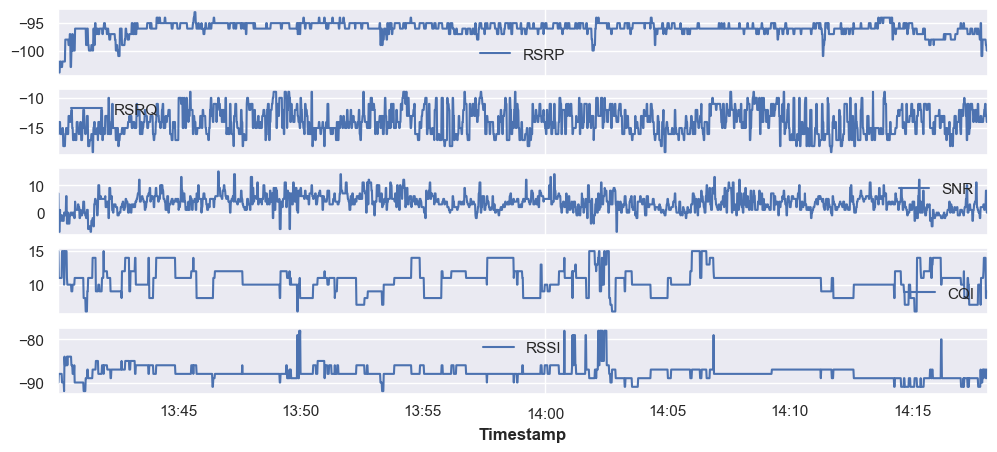

In [9]:
fig, ax = plt.subplots(5, 1)
test_df.plot(kind="line", sharex=True, y="RSRP", color="b", ax=ax[0])
test_df.plot(kind="line", sharex=True, y="RSRQ", color="b", ax=ax[1])
test_df.plot(kind="line", sharex=True, y="SNR", color="b", ax=ax[2])
test_df.plot(kind="line", sharex=True, y="CQI", color="b", ax=ax[3])
test_df.plot(kind="line", sharex=True, y="RSSI", color="b", ax=ax[4])

In [10]:
ts_static = TimeSeries.from_dataframe(
    test_df,
    value_cols=["RSRP", "RSRQ", "SNR", "CQI", "RSSI"],
    # fill_missing_dates=True,  # Adiciona NaN para os segundos ausentes
    # freq="s",
)

In [11]:
ts_static.pd_dataframe()

component,RSRP,RSRQ,SNR,CQI,RSSI
Timestamp,,,,,
2019-12-16 13:40:04,-103.0,-15.0,1.0,15.0,-90.0
2019-12-16 13:40:05,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:06,-102.0,-16.0,7.0,15.0,-90.0
2019-12-16 13:40:07,-104.0,-14.0,-7.0,11.0,-88.0
2019-12-16 13:40:08,-104.0,-14.0,-7.0,11.0,-88.0
...,...,...,...,...,...
2019-12-16 14:18:01,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:02,-99.0,-13.0,8.0,8.0,-89.0
2019-12-16 14:18:03,-100.0,-14.0,0.0,9.0,-87.0


## Verificação de Estacionaridade

### 1. Verificar a estacionaridade usando o Teste de Dickey-Fuller Aumentado

Uma série temporal é considerada "estacionária" se **não apresenta tendência**, exibe **variância constante** ao longo do tempo e possui uma estrutura de **autocorrelação constante** ao longo do tempo.

Uma maneira de testar se uma série temporal é estacionária é realizar um teste de **Dickey-Fuller aumentado**, que utiliza as seguintes hipóteses nulas e alternativas:

> $H_0$: A série temporal **não é estacionária**. Em outras palavras, ela possui alguma estrutura dependente do tempo e não apresenta variância constante ao longo do tempo.

> $H_A$: A série temporal **é estacionária**.

Se o **valor de p** do teste for **menor que** algum nível de **significância** (por exemplo, **α = 0,05**), então podemos **rejeitar a hipótese nula** e concluir que a série temporal **é estacionária**.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [58]:
# Teste de Dickey-Fuller Aumentado
result = adfuller(test_df["RSRP"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

ADF Statistic: -5.480676012356365
p-value: 2.2881082660140784e-06
A série é estacionária


Interpretação dos Resultados:

- **Estatística ADF (ADF Statistic):** Valor da estatística de teste. Valores mais negativos indicam uma série mais fortemente estacionária.
- **p-value:** Probabilidade associada ao teste. Um p-valor abaixo de 0.05 geralmente indica que a série é estacionária, pois rejeita a hipótese nula de que a série possui uma unidade raiz (não estacionária).
- **Valores Críticos (Critical Values):** Ponto de corte para diferentes níveis de significância (1%, 5%, e 10%).

## 2. Aplicação de Diferenciação para Remover Tendência. 

Se o p-valor do teste ADF for maior que 0.05, a série não é estacionária, e precisamos aplicar diferenciação.

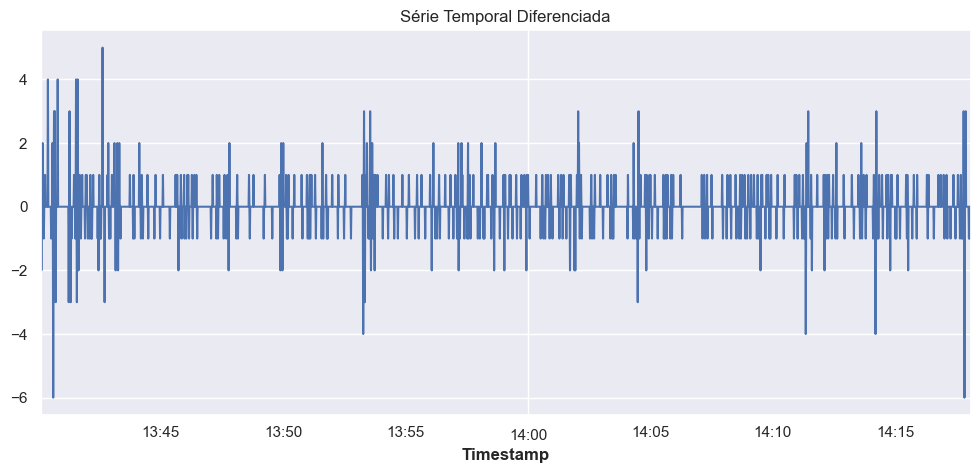

In [59]:
# Aplicando a primeira diferença
series_diff = test_df["RSRP"].diff().dropna()

# Visualizar a série diferenciada
series_diff.plot(title="Série Temporal Diferenciada")
plt.show()

In [60]:
# Teste de Dickey-Fuller na série diferenciada
result_diff = adfuller(series_diff)
print("ADF Statistic (differenced):", result_diff[0])
print("p-value (differenced):", result_diff[1])

ADF Statistic (differenced): -14.886086578209408
p-value (differenced): 1.5827554121195955e-27


A diferenciação pode ser aplicada repetidamente a uma série temporal até que ela se torne estacionária. No contexto de modelagem ARIMA, o número de vezes que a diferenciação é aplicada está relacionado com o parâmetro d do modelo ARIMA (p, d, q).

- **Evite Overdifferencing:** Diferenciar a série mais do que o necessário pode levar a problemas na modelagem e na interpretação dos resultados. Idealmente, o número de diferenciações deve ser o menor possível para alcançar a estacionaridade.
- **Análise Visual:** Além dos testes estatísticos, análises visuais dos gráficos de séries temporais diferenciadas, ACF, e PACF também são úteis para decidir o nível adequado de diferenciação.

### 3. Autocorrelação (ACF) e a autocorrelação parcial (PACF) para identificar componentes sazonais

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


- Autocorrelação (ACF): 
  - O gráfico de autocorrelação mostra a correlação da série com suas próprias versões defasadas (lags). Quando uma série temporal possui componentes sazonais, o gráfico de ACF geralmente mostra picos em lags múltiplos do período sazonal. Por exemplo, se há um padrão sazonal anual em dados mensais, picos significativos na ACF aparecerão nos lags 12, 24, 36, etc.
- Autocorrelação parcial (PACF): 
  - O gráfico de autocorrelação parcial mostra a correlação entre a série e suas defasagens, excluindo o efeito das defasagens intermediárias. Na presença de sazonalidade, a PACF pode mostrar picos significativos nos lags correspondentes ao período sazonal. A PACF é útil para entender a estrutura subjacente de um modelo autorregressivo e para diferenciar entre componentes sazonais e de tendência.

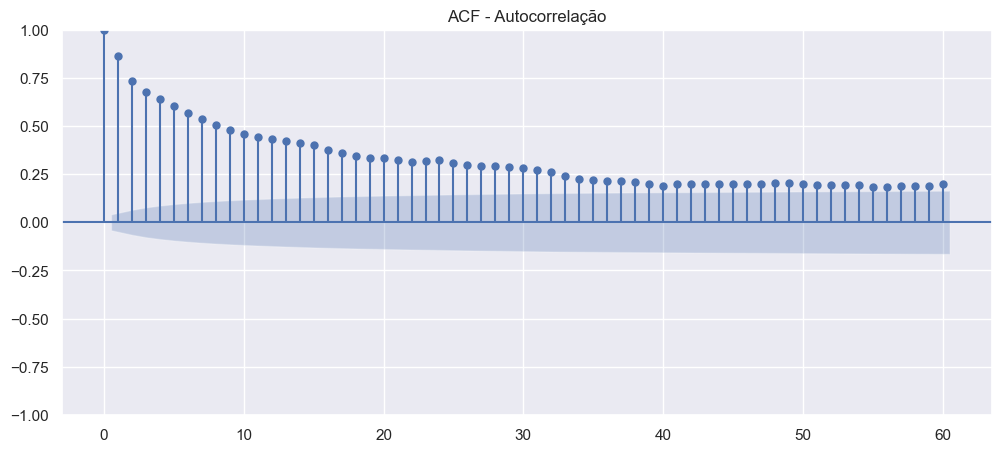

In [62]:
# Plotar ACF
plot_acf(test_df["RSRP"], lags=60)
plt.title("ACF - Autocorrelação")
plt.show()

Interpretação do ACF:
- Apresentar um comportamento decrescente sem picos significativos em lags específicos, isso geralmente indica que a série temporal não possui uma sazonalidade forte ou distinta.

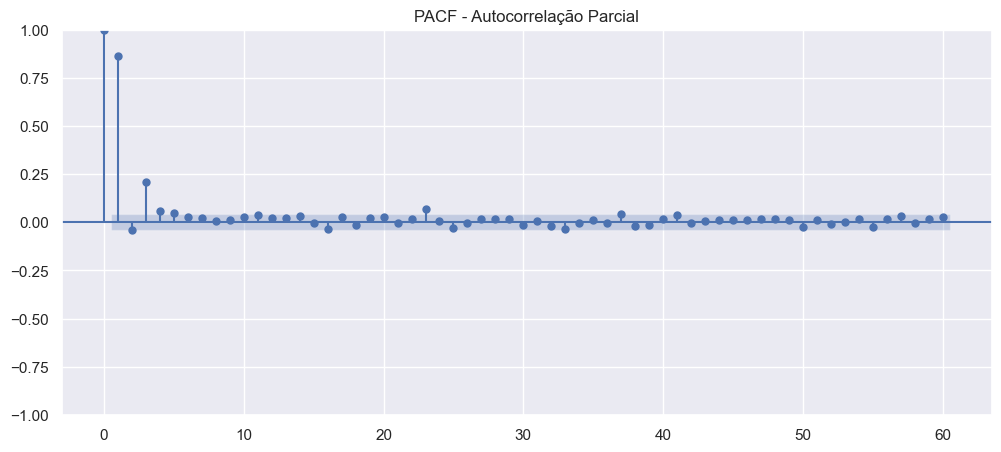

In [63]:
# Plotar PACF
plot_pacf(test_df["RSRP"], lags=60)
plt.title("PACF - Autocorrelação Parcial")
plt.show()

Interpretação do PACF:
- Valor Alto em Lag 0:
    -Lag 0 representa a autocorrelação da série com ela mesma, que é sempre 1, pois cada ponto está perfeitamente correlacionado consigo mesmo.
- Valores Altos nos Lags 1 e 2:
    -Valores altos em lag 1 e especialmente em lag 2 sugerem que a série tem uma dependência significativa dos valores observados dois períodos antes. Isso é típico de um processo autoregressivo de ordem 2 (AR(2)).

Interpretação dos Gráficos
- ACF: Um ACF que decresce exponencialmente pode sugerir que a série é bem representada por um modelo autoregressivo (AR), onde os valores são influenciados pelos valores anteriores, mas essa influência decai com o tempo. Neste caso, a PACF pode mostrar um corte abrupto após o primeiro ou segundo lag, o que ajuda a identificar a ordem do modelo AR.
- PACF com Corte Abaixo de um Certo Lag: Um corte claro na PACF após o primeiro ou segundo lag sugere um modelo AR de baixa ordem.

## The Hodrick-Prescott Filter:

Separetes a time-series $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$.

$$ y_t = \tau_t + c_t $$

In [64]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [65]:
RSRP_cycle, RSRP_trend = hpfilter(test_df["RSRP"], lamb=1600)

<Axes: xlabel='Timestamp'>

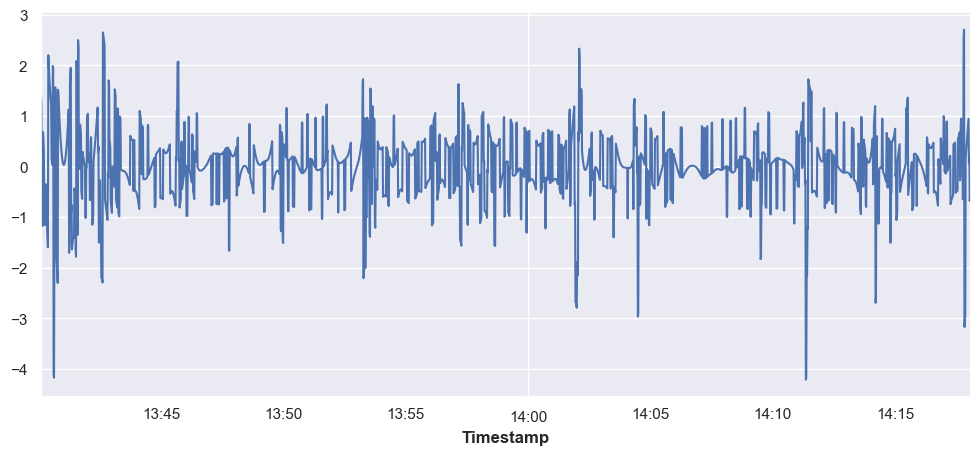

In [66]:
RSRP_cycle.plot()

<Axes: xlabel='Timestamp'>

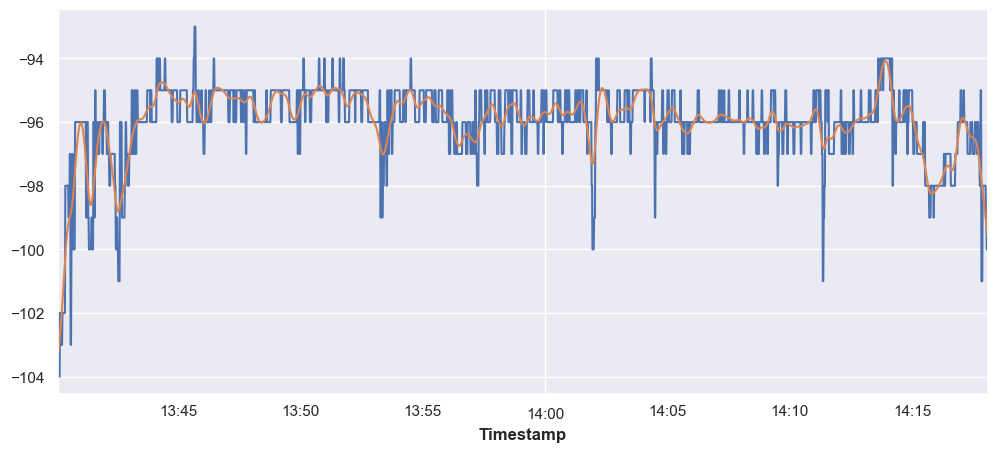

In [67]:
test_df["RSRP"].plot()
RSRP_trend.plot()

## The ETS (Error-Trend-Seasonality) Models:

ETS (Exponential Smoothing) is a time series forecasting technique that combines three main components: error (E), trend (T), and seasonality (S). It smooths past data to predict future values by applying exponentially decreasing weights over time. There are various types of ETS models, including additive and multiplicative models, depending on how trend and seasonality interact with the time series data. ETS is particularly useful for data exhibiting seasonal patterns and trends, enabling accurate forecasts in scenarios where these components are significant.

- An additive model is applied when the trend appears linear and both the seasonality and trend components seem constant over time.
- A multiplicative model is more appropriate when the trend is increasing (or decreasing) at a non-linear rate.

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

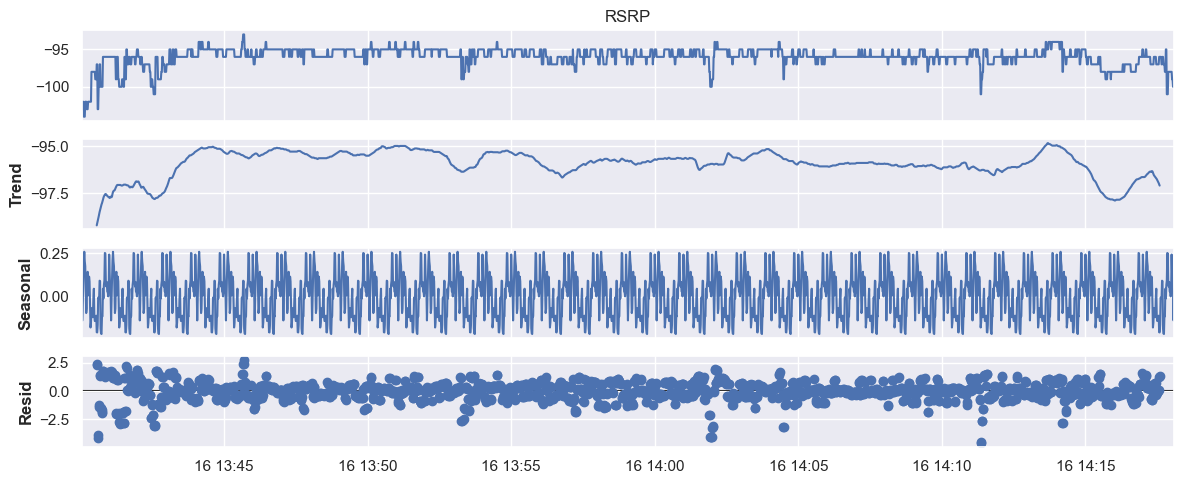

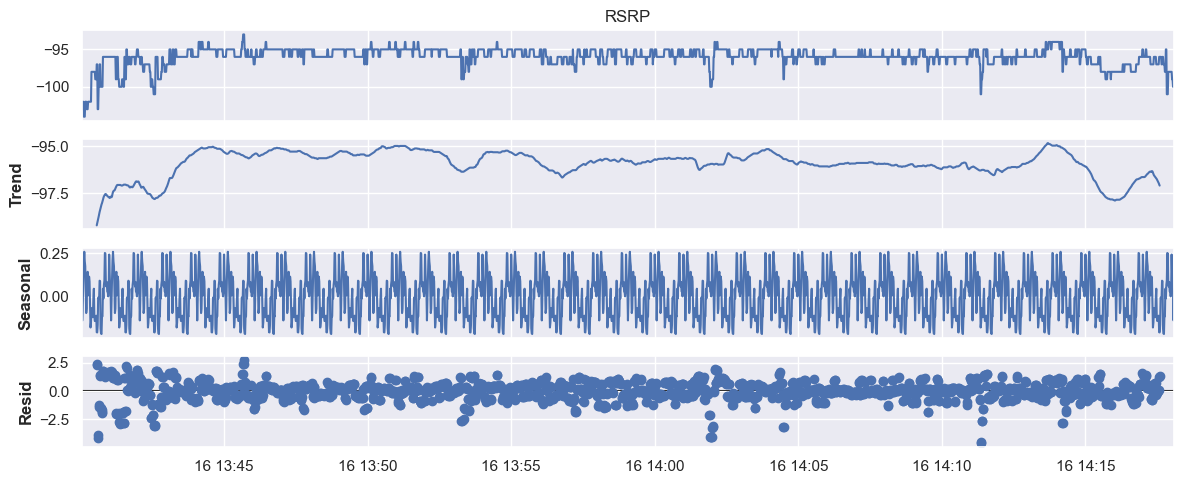

In [73]:
seasonal_decompose(test_df["RSRP"], model="add", period=60).plot()

## Rolling Moving Average

<Axes: xlabel='Timestamp'>

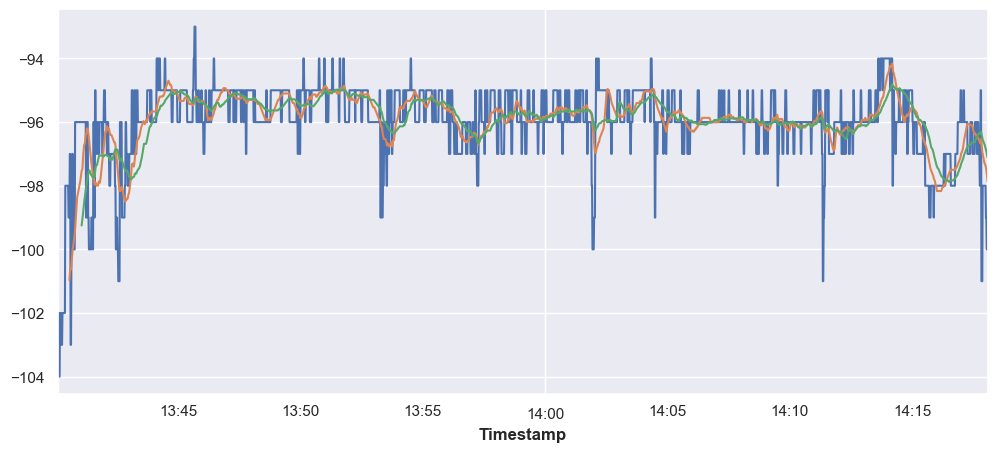

In [70]:
test_df["RSRP"].plot()
test_df["RSRP"].rolling(window=30).mean().plot()
test_df["RSRP"].rolling(window=60).mean().plot()

## EWMA (Exponentially weighted moving average)

<Axes: xlabel='Timestamp'>

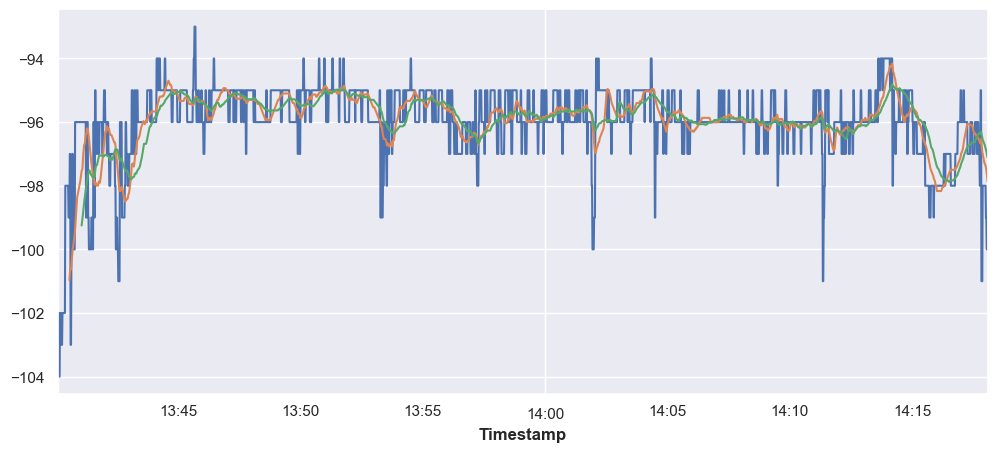

In [71]:
test_df["RSRP"].plot()
test_df["RSRP"].rolling(window=30).mean().plot()
test_df["RSRP"].rolling(window=60).mean().plot()

<Axes: xlabel='Timestamp'>

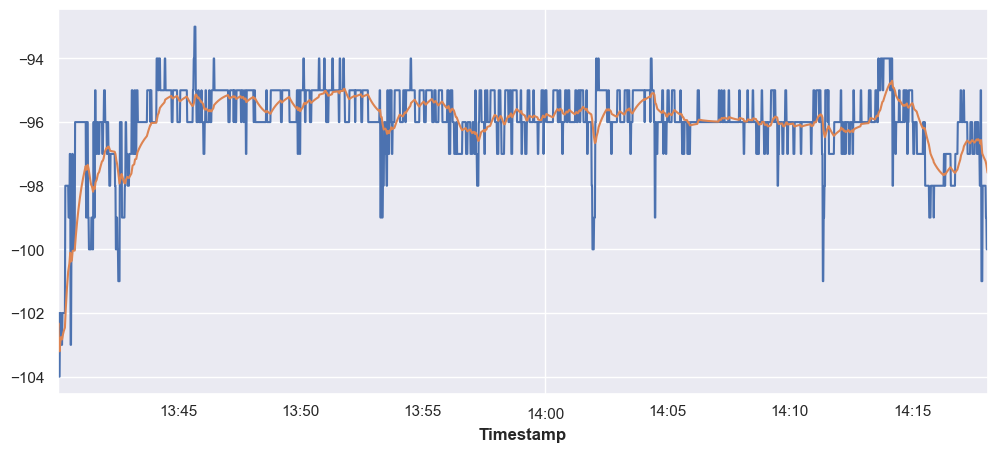

In [72]:
test_df["RSRP"].plot()
test_df["RSRP"].ewm(span=60).mean().plot()

Estudar:

  - https://www.youtube.com/watch?v=CAT0Y66nPhs
  - https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

Código para referência:

- https://github.com/KareemElozeiri/CQI-Timeseries-Forecasting/blob/main/notebooks/CQI_Time_Series_Forecasting.ipynb